<a href="https://colab.research.google.com/github/SSerov77/PrigSkock/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ПРЕДОБРАБОТКА ДАННЫХ

В этом блоке кода мы открываем файл, импортируем необходимые библиотеки и переводим столбцы в формат PEP8.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from scipy.stats import shapiro
from scipy.stats import spearmanr


df = pd.read_csv('data.csv', sep=';', decimal='.')

# Переводим столбцы в формат PEP8
df.columns = df.columns.str.lower().str.replace(' ', '_')


При просмотре данных мы заметели пропуски в колонке Возраст и решили заполнить их медианным значением, так как решили, что медианное значение будет максимально приближенно к реальным данным

In [ ]:
# Заполнение пропусков в столбце Возраст медианным значением
df['возраст'].fillna(df['возраст'].median(), inplace=True)

При просмотре данных мы обнаружили, что столбцы Возраст и Ощущение температуры в десятичном формате с 0 после запятой. Исходя из этого было принято решение перевести их в целочисленный формат для удобства в дальнейшей работе.

In [ ]:
# Переводим столбцы в целочисленный тип
def floatToInt(columns):
    for col in columns:
        df[col] = df[col].astype(int)


floatToInt(['ощущение_температуры', 'возраст'])

Мы нашли в данных опечатку в столбце Климат и исправили ее, также удалили 1 дубликатную строку.

In [ ]:
# Удаление дубликатов
duplicates = df[df.duplicated()]
df_no_duplicates = df.drop_duplicates()

# Удаление неявных дубликатов
df.loc[df["климат"] == "Cубтроп океанич", "климат"] = 'Cубтропический океанический'

При просмотре данных мы обнаруживаем некоторые выбросы в столбце Температура воздуха в помещении. Для того, чтобы убедиться действительно ли это выбросы мы строим график boxplot и по нему понимаем, что всё что выше 29°C - выбросы и ниже 20°C.<br>
Наиболее вероятностными причиной выбросов могут быть аномальная погода на улице или неполадки с измерительным оборудованием. Мы склоняемся ко второму варианту, так как первый отпадает по данным в столбце температуры воздуха на улице. Еще возможен третий вариант с опечаткой, но он тоже отпадает так как выбросы не имеют связи между собой.<br>
Помимо этого стоит обратить внимание на огромные выбросы, которые превышают 70. Скорее всего они взялись из-за ошибки в единицах измерения и вместо градусов Цельсия замеры проводились в Фаренгейтах.
Для этих выбросов мы сделаем отдельную выборку и обработку.

<Axes: ylabel='температура_воздуха_в_помещении'>

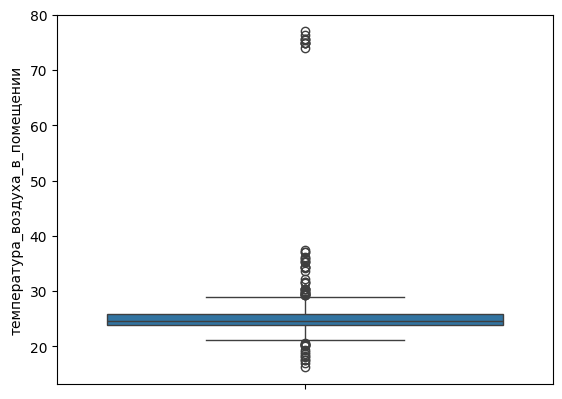

In [ ]:
sns.boxplot(df['температура_воздуха_в_помещении'])

Находим примерно 51 выбросов, которые попадают под диапазон выже 29°C и ниже 20°C.<br>
Итого количество выбросов: 51.<br>
Из них 9 мы заменим на другую единицу измерения.

In [ ]:
# Выбросы > 29
print(np.where(df['температура_воздуха_в_помещении'] > 29))
# Выбросы < 20
print(np.where(df['температура_воздуха_в_помещении'] < 20))
# Выбросы с ошибкой в ед. измерения
print(np.where(df['температура_воздуха_в_помещении'] >= 70))

(array([  1,   7,   9,  23,  33,  38,  41,  45,  54,  67, 271, 280, 289,
       290, 293, 296, 299, 322, 327, 328, 353, 358, 361, 362, 365, 367,
       369, 378, 382, 401, 404, 406, 408, 412, 425, 429, 431, 438, 440,
       443, 477, 479], dtype=int64),)
(array([275, 287, 319, 345, 357, 373, 392, 415, 435], dtype=int64),)
(array([ 1,  7,  9, 23, 33, 38, 41, 45, 54, 67], dtype=int64),)


Для замены наших выбросов можно использовать интерквартиильный размах. Нижняя граница получается 20°C, верхняя 29°C. Таким образом всего мы заменили 51 выброс, а 9 из них заменили на эквивалентные значения в градусах Цельсия. Остальные выбросы на медианное значение по климату, так как в зависимости от климата температура в помещении может разниться.<br>
Формула преобразования из Фаренгейтов в Цельсия: Ц = 5 / 9 * (Ф - 32)<br>
Источник откуда взяли формулу: https://clck.ru/37ANVT

In [ ]:
# Замена выбросов на эквивалентные значения в градусах Цельсия
max_temperature_fahrenheit = 70
outliers = df['температура_воздуха_в_помещении'] > max_temperature_fahrenheit
df.loc[outliers, 'температура_воздуха_в_помещении'] = (df.loc[outliers, 'температура_воздуха_в_помещении'] - 32) * 5/9


# Замена выбросов на медианное значение групп по климату
def replace_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound, upper_bound)
    df[column] = np.where((df[column] < lower_bound) | (
        df[column] > upper_bound), df.groupby('климат')[column].transform('median'), df[column])


replace_outliers('температура_воздуха_в_помещении')

20.950000000000003 28.549999999999997


Создаем еще один категориальный столбец, основываясь на данных Ощущения температуры. Мы решили распределить шкалу Ощущение температуры на 3 равные категории.<br>
    - От -3 до -1 - холодно;<br>
    - От -1 до 1 - нормально;<br>
    - От 1 до 3 - жарко.

In [ ]:
# Категории ощущения температуры
def addTemperatureCategory(comfortScore):
    if -3 <= comfortScore < -1:
        return 'холодно'
    elif -1 <= comfortScore <= 1:
        return 'нормально'
    elif 1 < comfortScore <= 3:
        return 'жарко'


df['категории_ощущения_температуры'] = df['ощущение_температуры'].apply(
    addTemperatureCategory)

print(df['категории_ощущения_температуры'])

0      нормально
1        холодно
2      нормально
3      нормально
4      нормально
         ...    
479    нормально
480    нормально
481    нормально
482    нормально
483    нормально
Name: категории_ощущения_температуры, Length: 484, dtype: object


Проводя графический анализ наиболее важным по нашему мнению нужно было показать соотношение категорий ощущений температуры и соотношение способов охлаждения, чтобы понять какое ощущение температуры преобладет, а также какой способ охлаждения является самым популярным. В результате получилось:<br>
По ощущению температуры:<br>
    - Холодно - 4,8%;<br>
    - Нормально - 84,9%;<br>
    - Жарко - 10,3%.<br>
    Отсюда можем сделать вывод, что большинство респондентов удовлетворены температурой.<br>
По Способу охлаждения:<br>
    - Вентиляция - 6,8%;<br>
    - Кондиционнирование - 23,6%;<br>
    - Смешанный - 69,6%.<br>
    Отсюда можем сделать вывод, что наибольшей популярностью обладает Смешанный тип. Это подтверждается еще и тем, что он используется во всех 5 климатах.<br>

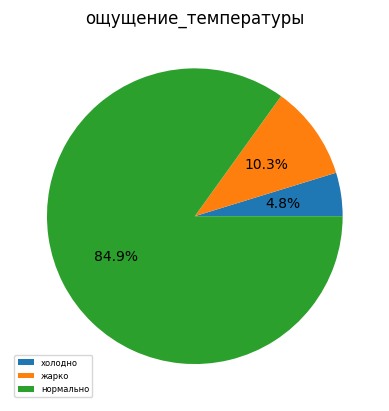

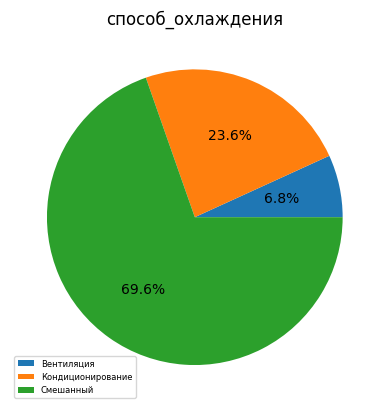

In [ ]:
# Отрисовываем катеригориальные диаграммы
def drawDiagramStandart(column, name_title):
    count = df[column].value_counts(ascending=True).to_dict()
    plt.title(name_title)
    plt.pie(df[column].value_counts(
        ascending=True), autopct='%1.1f%%')
    plt.legend(count.keys(), loc='lower left', prop={'size': 6})
    plt.show()

# График ощущения температуры по категориям
drawDiagramStandart('категории_ощущения_температуры', 'ощущение_температуры')

# График популярности способов охлаждения
drawDiagramStandart('способ_охлаждения', 'способ_охлаждения')

Также, мы посчитали важным провести графический анализ по популярности способ охлаждения в зависимости от климата. Благодаря нему мы можем понять, какой способ охлаждения является более востребованным в том или ином регионе. В результате получилось:<br>
Смешанным типом:<br>
    - Субтропическое высокогорье - 5,6%;<br>
    - Влажный субтропический муссонный - 5,6%;<br>
    - Тропическая влажная саванна - 11,6%;<br>
    - Жаркий полузасушлевый - 18,4%;<br>
    - Субтропический океанический - 58,8%.<br>
    По итогу мы получили, что Смешанный тип используется во всех климатах. Лидирующим является Субтропический океанический.<br>
Кондиционированнием:<br>
    - Влажный субтропический муссонный - 14%;<br>
    - Тропическая влажная саванна - 22,8%;<br>
    - Субтропический океанический - 63,2%.<br>
    По итогу мы получили, что Конидционирование используется только в 3 климатах. Лидирующим является Субтропический океанический.<br>
Вентиляцией:<br>
    - Субтропическое высокогорье - 39,4%;<br>
    - Влажный субтропический муссонный - 36,4%;<br>
    - Жаркий полузасушлевый - 24,2%.<br>
    По итогу мы получили, что Вентилияцией пользуются только в 3 климатах. Лидирующим является Субтропическое высокогорье.



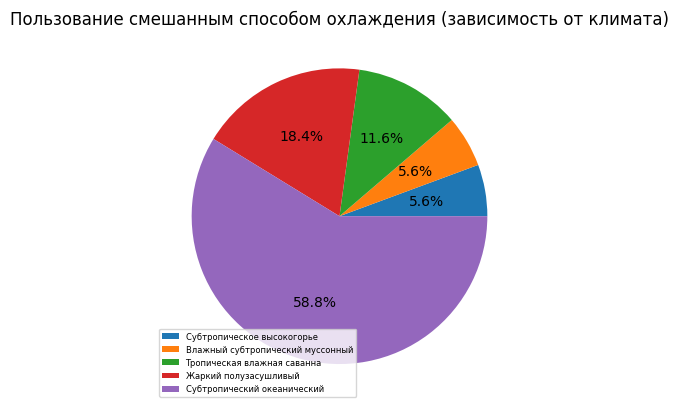

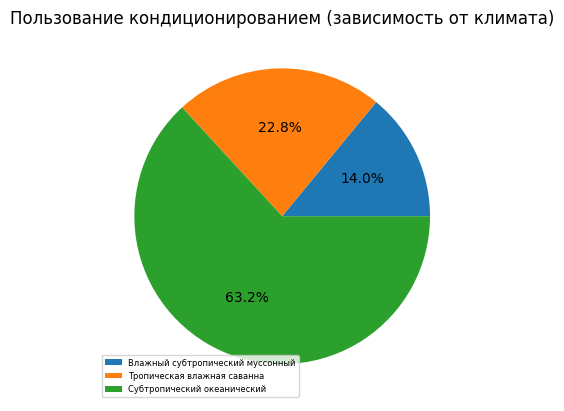

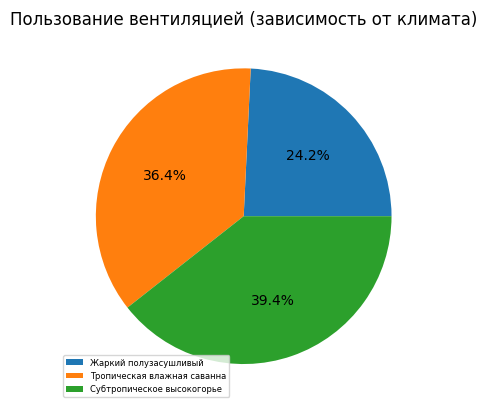

In [ ]:
# Отрисовываем Климатические диаграммы
def drawDiagramClimate(method_cooling, name_title):
    df_1 = df[(df['способ_охлаждения'] == method_cooling)]
    count = df_1['климат'].value_counts(ascending=True).to_dict()
    plt.title(name_title)
    plt.pie(df_1['климат'].value_counts(ascending=True), autopct='%1.1f%%')
    plt.legend(count.keys(), loc='lower left', prop={'size': 6})
    plt.show()

# График популярности Смешанного типа по климату
drawDiagramClimate(
    'Смешанный', 'Пользование смешанным способом охлаждения (зависимость от климата)')

# График популярности Кондиционировая по климату
drawDiagramClimate('Кондиционирование',
                   'Пользование кондиционированием (зависимость от климата)')

# График популярности Вентиляции по климату
drawDiagramClimate(
    'Вентиляция', 'Пользование вентиляцией (зависимость от климата)')

# РАСЧЕТЫ И ИСЛЕДОВАНИЯ

Создаем категориальный столбец по количеству рекламаций. Если у нас замечено:<br>
    - Если < 1 рекламаций -  мало;<br>
    - Если 2 - средне;<br>
    - Если рекламаций > 3 - много.<br>
Всего получилось 3 категории.

In [ ]:
# Категории рекламаций
def addClaimCategory(claimCount):
    if claimCount <= 1:
        return 'мало'
    elif 2 == claimCount:
        return 'средне'
    else:
        return 'много'


df['категории_рекламаций'] = df['количество_рекламаций'].apply(addClaimCategory)
print(df['категории_рекламаций'])



0      мало
1      мало
2      мало
3      мало
4      мало
       ... 
479    мало
480    мало
481    мало
482    мало
483    мало
Name: категории_рекламаций, Length: 484, dtype: object


Создаем категориальный столбец по возрасту.<br>
    - Все кому меньше 45 - молодые;<br>
    - Те, кому от 45 до 59 - среднего возраста;<br>
    - Те, кто старше 59 - пожилые.<br>
Всего получилось 3 категории.

In [ ]:
# Категории возрастов
def addAgeCategory(age):
    if age < 45:
        return 'молодой'
    elif 45 <= age <= 59:
        return 'средний'
    else:
        return 'пожилой'


df['категории_возраста'] = df['возраст'].apply(addAgeCategory)
print(df['категории_возраста'])

0      молодой
1      молодой
2      молодой
3      молодой
4      средний
        ...   
479    молодой
480    молодой
481    молодой
482    молодой
483    молодой
Name: категории_возраста, Length: 484, dtype: object


Находим среднюю оценку комфорта по ворастным категориям. Для этого создаем сводную таблицу.<br>
В результате у нас получилось:<br>
    - молодые - 24°C;<br>
    - пожилые - 25°C;<br>
    - средний - 24°C.<br>
Отсюда можем сделать вывод, что все респондеты +-1°C любят одну температуру.<br>

In [ ]:
# Средняя комфортная температура по возрастным категориям
filtered_data = df[df['категории_ощущения_температуры'] == 'нормально']
middle_comfortable_temperature = filtered_data.groupby('категории_возраста')['температура_воздуха_в_помещении'].mean().reset_index()
print(middle_comfortable_temperature)

  категории_возраста  температура_воздуха_в_помещении
0            молодой                        24.910334
1            пожилой                        25.009091
2            средний                        24.121019


Находим средний возраст по Полу и Стране. Из-за того, что у нас не представлены данные по полу в США мы не смогли определить средний возраст каждого пола и нашли только общий средний возраст по стране.<br>
В результате у нас получилось:<br>
    - Жен. в Австралии - 46;<br>
    - Жен. в Индии - 38;<br>
    - Муж. в Австралии - 42;<br>
    - Муж. в Индии - 39;<br>
    - В США общий средний возраст - 36.<br>
По итогу можем сделать вывод, что наиболее взрослые респонденты находятся в Австралии. А наиболее молодые в США.

In [ ]:
# Cредний возраст по полу и стране
middle_age_by_gender_and_country = df.groupby(
    ['пол', 'страна'])['возраст'].mean().reset_index()
print(middle_age_by_gender_and_country)

# Cредний возраст в США
filtered_data = df[df['страна'] == 'США']
middle_age_in_usa = filtered_data['возраст'].mean()
print('США:', middle_age_in_usa)

       пол     страна    возраст
0  Женский  Австралия  46.348315
1  Женский      Индия  38.550725
2  Мужской  Австралия  42.614679
3  Мужской      Индия  39.496552
США: 36.208333333333336


Создаем сводную таблицу, в которой показана Медиана температуры в помещении и влажности по способу охлаждения.<br>
По итогу мы получили:<br>
Температура в помещении:<br>
    - Вентиляция - 25.3°C;<br>
    - Кондиционирование - 24.3°C;<br>
    - Смешанный - 24.6°C;<br>
    Отсюда можем сделать вывод, что температура у всех +-1°C одинакова.<br>
Относительная влажность:<br>
    - Вентиляция - 46.30%;<br>
    - Кондиционирование - 42.45%;<br>
    - Смешанный - 56.30%.<br>
    Отсюда можем сделать вывод, что при Смешанном типе влажность повышенная, в отличие от двух других.<br>

In [ ]:
# Медиана температуры и влажности по способу охлаждения
median_of_the_cooling_type = df.groupby('способ_охлаждения')[
    ['температура_воздуха_в_помещении', 'rh']].median().reset_index()
print(median_of_the_cooling_type)

   способ_охлаждения  температура_воздуха_в_помещении     rh
0         Вентиляция                        25.300000  46.30
1  Кондиционирование                        24.277778  42.45
2          Смешанный                        24.600000  56.30


Создаем количественный столбец, в котором показан процент респондентов поставивших оценку комфорта не меньше 4. Австралия и США не считаются, так как по Австралии не даны данные Оценки комфорта, а США не даны данные по Полу. Заполнять пропуски в столбце Оценка комфорта мы не стали, так отсутствует полная информация по этой стране в этом столбце и опираться на данные других стран будет неточно.Тоже самое касается заполнения пропусков по Полу в США. Для США мы решили посчитать общий процент удовлетворенных по стране.<br>
В результате мы получили:<br>
      - В США 62% ответили, что вполне удолетворены;<br>
      - В Индии Жен. 55%;<br>
      - В Индии Муж. 60%;<br>
      - По Австралии данных нет.

In [ ]:
# Процент удовлетворенных
df.set_index(['страна', 'пол'], inplace=True)
df['процент_удовлетворенных'] = df.groupby(['страна', 'пол'])[
    'оценка_комфорта'].apply(lambda x: (x >= 4).mean() * 100)
df.reset_index(inplace=True)
print(df['процент_удовлетворенных'])

# Процент удовлетворенных в США
filtered_data = df[df['страна'] == 'США']
percent_satisfied = filtered_data.groupby(['страна'])[
    'оценка_комфорта'].apply(lambda x: (x >= 4).mean() * 100)
print(percent_satisfied)


0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
         ...    
479    60.000000
480    60.000000
481    55.072464
482    55.072464
483    55.072464
Name: процент_удовлетворенных, Length: 484, dtype: float64
страна
США    62.5
Name: оценка_комфорта, dtype: float64


Создали сводную таблицу, в которой данные сгруппированы по стране, полу, возрастной группе и посчитаны средняя температура воздуха в помещении,
на улице и средняя относительная влажность для каждой из этих групп.

In [ ]:
# Cводная таблица, в которой данные сгруппированы по стране, полу, возрастной группе и посчитаны средняя температура воздуха в помещении,
# на улице и средняя относительная влажность для каждой из этих групп
pivot_table = df.pivot_table(index=['страна', 'пол', 'категории_возраста'],
                             values=['температура_воздуха_в_помещении',
                                     'температура_воздуха_на_улице', 'rh'],
                             aggfunc='mean').reset_index()
print(pivot_table)


       страна      пол категории_возраста         rh  \
0   Австралия  Женский            молодой  61.368000   
1   Австралия  Женский            пожилой  44.550000   
2   Австралия  Женский            средний  61.266071   
3   Австралия  Мужской            молодой  61.668889   
4   Австралия  Мужской            пожилой  64.366667   
5   Австралия  Мужской            средний  61.680328   
6       Индия  Женский            молодой  49.594444   
7       Индия  Женский            средний  49.940000   
8       Индия  Мужской            молодой  49.542000   
9       Индия  Мужской            пожилой  78.800000   
10      Индия  Мужской            средний  52.761364   

    температура_воздуха_в_помещении  
0                         23.840000  
1                         24.900000  
2                         24.112500  
3                         24.146667  
4                         24.733333  
5                         24.044262  
6                         25.659259  
7                      

Добавили новый категориальный столбец, в котором показано удовлетворяет ли зафиксированная относительная влажность стандарту или нет.<br>
Источник откуда взяли стандарт влажности: https://clck.ru/37ANJB<br>
По итогу мы получили, что только 244 из 483 удовлетворяет стандарту. Это почти 50%.

In [ ]:
# Новый категориальный столбец в котором показано удовлетворяет ли зафиксированная относительная влажность стандарту или нет.
df['rh_удовлетворяет_ли_стандарту'] = df['rh'].apply(
    lambda x: 'Да' if 40 <= x <= 60 else 'Нет')
print(df['rh_удовлетворяет_ли_стандарту'])

# Количество удовлетворенных относительной влажности
a = df[df['rh_удовлетворяет_ли_стандарту'] == 'Да'].shape
print(a[0])

0       Да
1      Нет
2      Нет
3       Да
4      Нет
      ... 
479    Нет
480    Нет
481     Да
482     Да
483     Да
Name: rh_удовлетворяет_ли_стандарту, Length: 484, dtype: object
244


Заменяем категории в категориальных столбцах на числа для проведения расчетов.<br>
Удаляем столбцы, которые не нужны нам в расчетах из-за недостаточности данных или по другим причинам.<br>
Для подсчета корреляции между параметрами мы построим график heatmap. На нем представлены все столбцы и связь между ними.<br>
Наиболее коррелирующие параметры: Температура воздуха в помещении и Температура воздуха на улице. Утепление и Процент удовлетворенных. Вентилятор и Скорость воздуха.

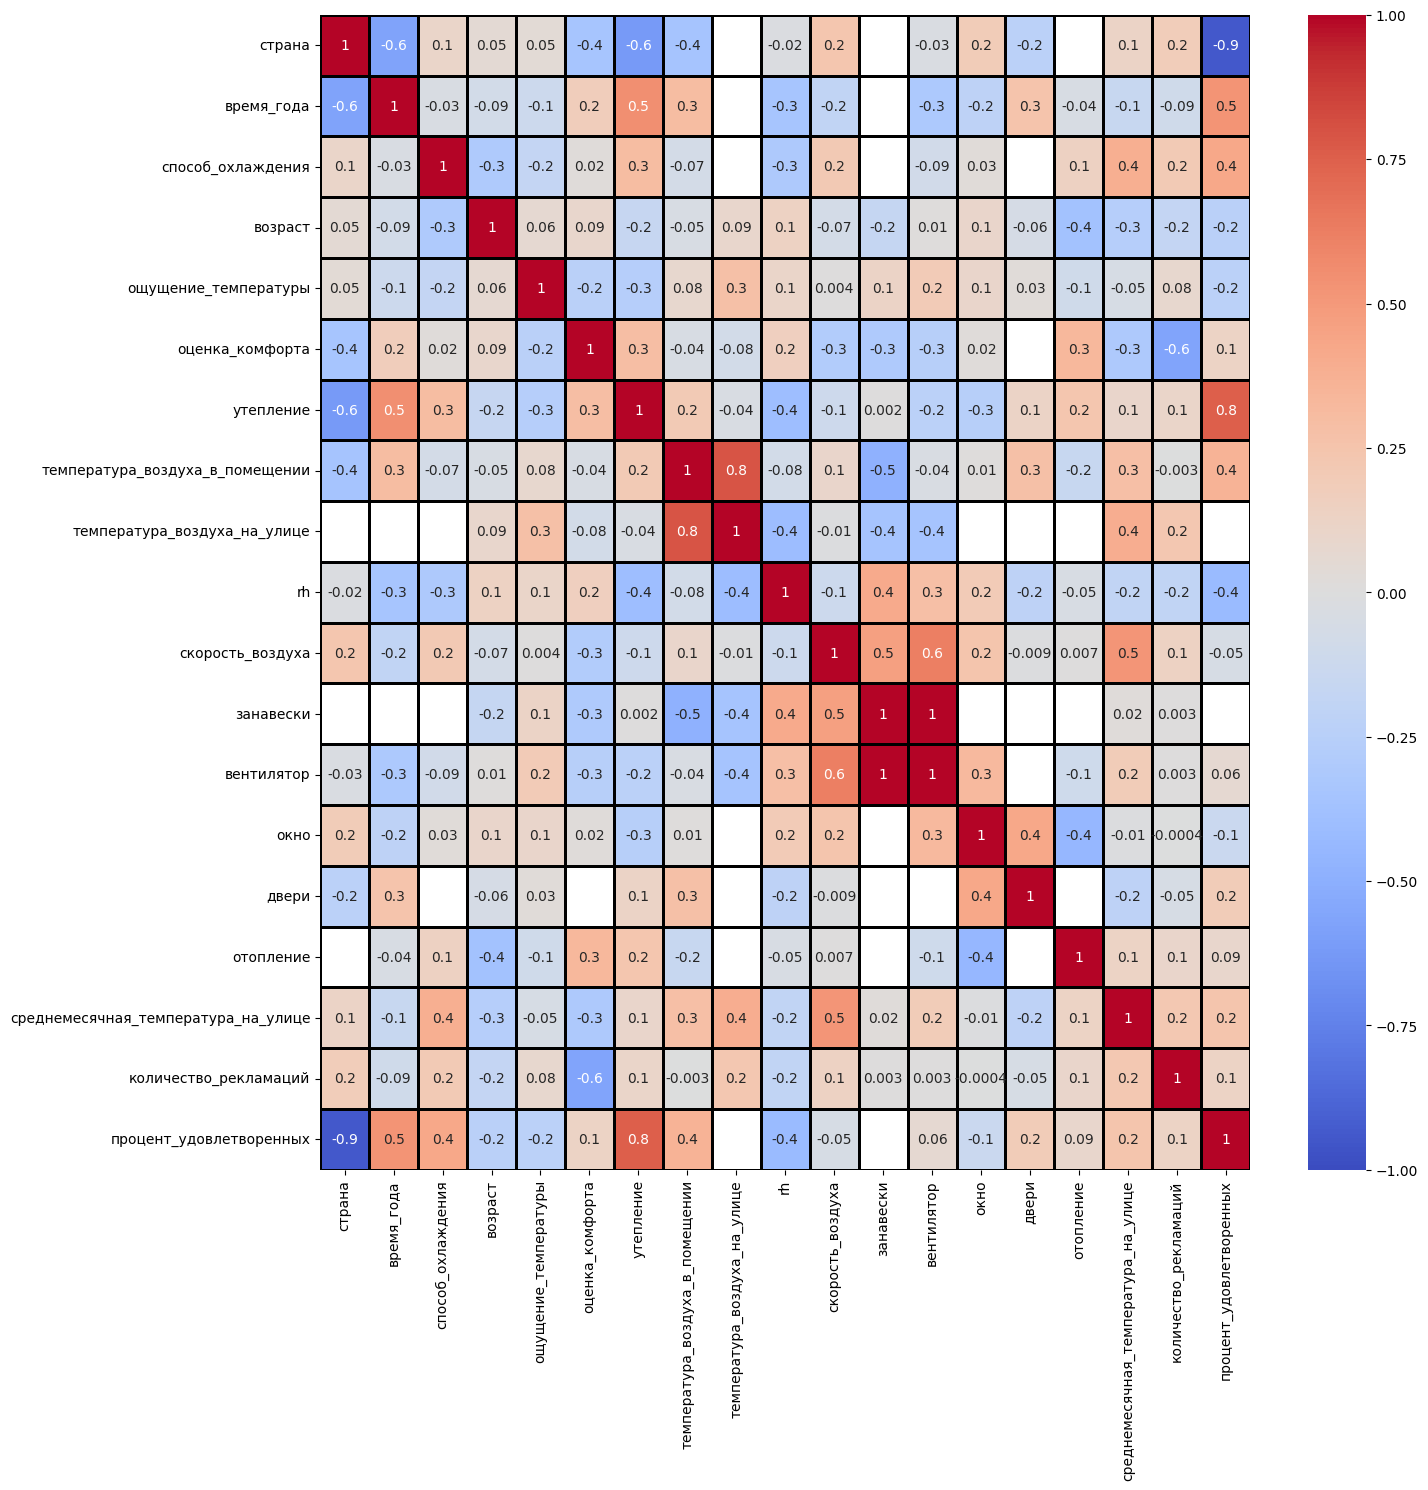

In [ ]:
# Создаем копию датафрейма
new_df = df.copy()

# Замена категорий в колонке на числа для проведения исследований
def replace_category_in_column(column, category, num):
    new_df[column] = new_df[column].replace(category, num)


replace_category_in_column('страна', 'Индия', 1)
replace_category_in_column('страна', 'Австралия', 2)
replace_category_in_column('страна', 'США', 3)

replace_category_in_column('способ_охлаждения', 'Смешанный', 1)
replace_category_in_column('способ_охлаждения', 'Кондиционирование', 2)
replace_category_in_column('способ_охлаждения', 'Вентиляция', 3)

replace_category_in_column('пол', 'Мужской', 1)
replace_category_in_column('пол', 'Женский', 2)

replace_category_in_column('время_года', 'Лето', 1)
replace_category_in_column('время_года', 'Зима', 2)
replace_category_in_column('время_года', 'Весна', 3)
replace_category_in_column('время_года', 'Осень', 4)

new_df = new_df.drop(columns=['способ_обогрева', 'год', 'пол', 'климат', 'город', 'режим_при_смешанном_типе_охлаждения', 'предпочтительное_изменение_температуры',
'предпочтительное_изменение_движения_воздуха', 'ощущение_температуры_(bool)', 'ощущение_движения_воздуха_(bool)', 'рост', 'вес', 'категории_ощущения_температуры',
'категории_возраста', 'rh_удовлетворяет_ли_стандарту', 'категории_рекламаций'], axis=1)
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(new_df.corr(method='spearman'), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0, cmap='coolwarm', linewidths=2, linecolor='black')
plt.show()

# ПРОВЕРКА ГИПОТЕЗ

Проверка гипотезы "Влияет ли способ охлаждения на оценку комфорта?"<br>
Заменяем категории в колонке на числа для проведения исследований.<br>
H0 - способ охлаждения не влияет на оценку комфорта.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что есть неслучайная зависимость, мы отвергаем нулевую гипотезу.<br>

In [ ]:
# Замена категорий в колонке на числа для проведения исследований
def replace_category_in_column(column, category, num):
    df[column] = df[column].replace(category, num)


# Заполняем Оценку комфорта медианой.
df['оценка_комфорта'].fillna(
    round(df['оценка_комфорта'].median(), 3), inplace=True)

replace_category_in_column('способ_охлаждения', 'Смешанный', 1)
replace_category_in_column('способ_охлаждения', 'Кондиционирование', 2)
replace_category_in_column('способ_охлаждения', 'Вентиляция', 3)

# Проверка гипотезы "Влияет ли способ охлаждения на оценку комфорта?"
# H0 - способ охлаждения не влияет на оценку комфорта
a = shapiro(df['оценка_комфорта'])
b = shapiro(df['способ_охлаждения'])
print(a, b)
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни,
manna = stats.mannwhitneyu(
    df['способ_охлаждения'], df['оценка_комфорта'], alternative='two-sided')
print(manna)
# получаем р-уровень меньше 0.05, что говрит о том, что есть неслучайная зависимость, мы отвергаем нулевую гипотезу.

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=0.6257041096687317, pvalue=4.313160077263143e-31)
MannwhitneyuResult(statistic=1703.0, pvalue=5.67547914059243e-169)


Проверка гипотезы "Влияет ли пол на оценку комфорта?".<br>
H0 - пол не влияет на оценку комфорта.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу р-уровень меньше 0.05, что говорит о том, что есть неслучайная зависимость, мы отвергаем нулевую гипотезу.<br>

In [ ]:
# Проверка гипотезы "Влияет ли пол на оценку комфорта?"
a = shapiro(df['оценка_комфорта'])
#H0 - пол не влияет на оценку комфорта
replace_category_in_column('пол', 'Мужской', 1)
replace_category_in_column('пол', 'Женский', 2)
b = shapiro(df['пол'])
print(a, b)
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни,
manna = stats.mannwhitneyu(
    df['пол'], df['оценка_комфорта'], alternative='two-sided')
print(manna)

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=nan, pvalue=1.0)
MannwhitneyuResult(statistic=nan, pvalue=nan)


Проверка гипотезы "Влияет ли возраст на оценку комфорта?".<br>
H0 - возраст не влияет на оценку комфорта.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:

# Проверка гипотезы "Влияет ли возраст на оценку комфорта?"
a = shapiro(df['оценка_комфорта'])
# H0 - возраст не влияет на оценку комфорта
replace_category_in_column('категории_возраста', 'молодой', 1)
replace_category_in_column('категории_возраста', 'средний', 1)
replace_category_in_column('категории_возраста', 'пожилой', 1)
b = shapiro(df['категории_возраста'])
print(a, b)
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни,
manna = stats.mannwhitneyu(
    df['категории_возраста'], df['оценка_комфорта'], alternative='two-sided')
print(manna)
# получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=1.0, pvalue=1.0)
MannwhitneyuResult(statistic=242.0, pvalue=8.4854798382223e-190)


c:\Users\serge\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


Проверка гипотезы "Есть связь между количеством рекламаций и оценкой комфорта?".<br>
H0 - оценка комфорта не зависит от количества рекламаций.<br>
Так как у нас шкалы количественные и данные распределены ненормально используем тест Спирмена.<br>
По итогу р-уровень меньше 0.05, это говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:
# Проверка гипотезы "Есть связь между количеством рекламаций и оценкой комфорта?"
# H0 - оценка комфорта не зависит от количества рекламаций
a = shapiro(df['оценка_комфорта'])
b = shapiro(df['количество_рекламаций'])
print(a, b)
# так как у нас шкалы количественные и данные распределены ненормально \
# используем тест Спирмена,
manna = spearmanr(
    df['количество_рекламаций'], df['оценка_комфорта'])
print(manna)
# так как р-уровень меньше 0.05, это говорит о том, что мы отвергаем нулевую гипотезу

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=0.25287389755249023, pvalue=4.646061110407504e-40)
SignificanceResult(statistic=-0.46843414188716254, pvalue=9.069666501602382e-28)


Проверка гипотезы "Средняя оценка меняется в зависимости от страны?".<br>
H0 - оценка комфорта не зависит от страны.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:
# Проверка гипотезы "Средняя оценка меняется в зависимости от страны?"
df_1 = df[(df['страна'] == 'Индия')]
print('Индия:', round(df_1['оценка_комфорта'].mean(), 2))
df_2 = df[(df['страна'] == 'Австралия')]
print('Австралия:', round(df_2['оценка_комфорта'].mean(), 2))
df_3 = df[(df['страна'] == 'США')]
print('США:', round(df_3['оценка_комфорта'].mean(), 2))

replace_category_in_column('страна', 'Индия', 1)
replace_category_in_column('страна', 'Австралия', 2)
replace_category_in_column('страна', 'США', 3)

a = shapiro(df['оценка_комфорта'])
b = shapiro(df['страна'])
print(a, b)
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни
# H0 - оценка комфорта не зависит от страны
manna = stats.mannwhitneyu(
    df['страна'], df['оценка_комфорта'], alternative='two-sided')
print(manna)
# получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу

Индия: 5.04
Австралия: 5.0
США: 4.19
ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=0.7775812745094299, pvalue=4.0209916668538566e-25)
MannwhitneyuResult(statistic=3176.0, pvalue=9.904042279830458e-161)


Проверка гипотезы "Есть связь между ощущением температуры и весом?"<br>
H0 - ощущение температуры и вес не связаны.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:
# Проверка гипотезы "Есть связь между ощущением температуры и весом?"
replace_category_in_column('категории_ощущения_температуры', 'холодно', 1)
replace_category_in_column('категории_ощущения_температуры', 'нормально', 2)
replace_category_in_column('категории_ощущения_температуры', 'жарко', 3)
a = shapiro(df['категории_ощущения_температуры'])
b = shapiro(df['вес'])
print(a, b)
# H0 - ощущение температуры и вес не связаны
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни,
manna = stats.mannwhitneyu(
    df['вес'], df['категории_ощущения_температуры'], alternative='two-sided')
print(manna)

ShapiroResult(statistic=0.5257143974304199, pvalue=4.973869705811826e-34) ShapiroResult(statistic=nan, pvalue=1.0)
MannwhitneyuResult(statistic=nan, pvalue=nan)


Проверка гипотезы "Есть связь между оценкой комфорта и весом?".<br>
Оценка комфорта и вес никак не связаны.<br>
Так как у нас шкалы количественные и данные распределены ненормально используем тест Спирмена.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:
# Проверка гипотезы "Есть связь между оценкой комфорта и весом?"
a = shapiro(df['оценка_комфорта'])
b = shapiro(df['вес'])
# Оценка комфорта и вес никак не связаны
# так как у нас шкалы количественные и данные распределены ненормально \
# используем тест Спирмена,
print(a, b)
manna = spearmanr(df['количество_рекламаций'], df['оценка_комфорта'])
print(manna)
# получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=nan, pvalue=1.0)
SignificanceResult(statistic=-0.46843414188716254, pvalue=9.069666501602382e-28)


Проверка "Есть связь между оценкой комфорта и ощущением температуры?".<br>
H0 - ощущение температуры и вес не связаны.<br>
Так как у нас шкалы количественная и номинальная и данные распределены ненормально используем тест Манна-Уитни.<br>
По итогу получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу.

In [ ]:
# Проверка "Есть связь между оценкой комфорта и ощущением температуры?"
a = shapiro(df['оценка_комфорта'])
b = shapiro(df['категории_ощущения_температуры'])
print(a, b)
# H0 - ощущение температуры и вес не связаны
# так как у нас шкалы количественная и номинальная и данные распределены ненормально \
# используем тест Манна-Уитни,
manna = stats.mannwhitneyu(
    df['категории_ощущения_температуры'], df['оценка_комфорта'], alternative='two-sided')
print(manna)
# получаем р-уровень меньше 0.05, что говорит о том, что мы отвергаем нулевую гипотезу

ShapiroResult(statistic=0.7205742597579956, pvalue=1.1752551262490703e-27) ShapiroResult(statistic=0.5257143974304199, pvalue=4.973869705811826e-34)
MannwhitneyuResult(statistic=3647.0, pvalue=3.108493328174873e-170)


# РЕГРЕССИОННАЯ МОДЕЛЬ

MAE(средняя абсолютная ошибка) - это оценка того, насколько близки предсказания к фактическим значениями.<br>
MSE(средняя квадратическая ошибка) - это оценка среднего значения квадрата ошибок, различие между предсказанием и фактическим значением. Эту метрику удобно использовать для выявления аномалий.<br>

MAE выводит 0.4, то есть значения которые выводит наша модель достоверная и ей можно доверять<br>
MSE выводит 0.25, то есть наша модель ошибается на это значение, значит выводимые значения модели близки к фактическим значениям

In [ ]:
new_df = df[['температура_воздуха_в_помещении', 'ощущение_температуры',
             'способ_охлаждения', 'температура_воздуха_на_улице']].dropna()
data = new_df['температура_воздуха_в_помещении']
new_df.drop('температура_воздуха_в_помещении', axis=1, inplace=True)

new_df['способ_охлаждения'] = new_df['способ_охлаждения'].replace(
    'Кондиционирование', 0)
new_df['способ_охлаждения'] = new_df['способ_охлаждения'].replace(
    'Вентиляция ', 1)
new_df['способ_охлаждения'] = new_df['способ_охлаждения'].replace(
    'Смешанный ', 2)
x_train, x_test, y_train, y_test = train_test_split(
    new_df, data, test_size=0.2, random_state=42)

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown="ignore")
ohe.fit(x_train[['способ_охлаждения']])

model = LinearRegression()
model.fit(x_train, y_train)
p = model.predict(x_test)

print(np.round(p))
#MSE(средняя квадратическая ошибка)—это оценка среднего значения квадрата ошибок, различие между предсказанием и фактическим значением. Эту метрику удобно использовать для выявления аномалий.
#MAE(средняя абсолютная ошибка)—это оценка того, насколько близки предсказания к фактическим значениями.
mae = round(mean_absolute_error(y_test, p), 2)
mse = round(mean_squared_error(y_test, p), 2)
#MAE выводит 0.4, то есть значения которые выводит наша модель достоверная и ей можно доверять
#MSE выводит 0.25, то есть наша модель ошибается на это значение, значит выводимые значения модели близки к фактическим значениям
print(mse, mae)

[24. 24. 24. 23. 25. 24. 25. 24. 25. 24. 24. 24. 25. 23. 24.]
0.19 0.32
